Original code from https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py under the following license:

MIT License

Copyright (c) 2017 Erik Linder-Norén

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

The author's model was based on the paper here: https://arxiv.org/pdf/1511.06434.pdf

# Instructions

1. Go to https://colab.research.google.com and choose the \"Upload\" option to upload this notebook file.
1. In the Edit menu, choose \"Notebook Settings\" and then set the \"Hardware Accelerator\" dropdown to GPU.
1. Read through the code in the following sections:
  * [Define functions for model creation and training](#scrollTo=v7awMKS210hl)
  * [Create model objects](#scrollTo=suz991e610h-)
  * [Train model](#scrollTo=_ig7giYA10i0)
1. Complete at least one of these exercises
  * [Exercise Option #1 - Standard Difficulty](#scrollTo=NfUM0c3_10j4)
  * [Exercise Option #2 - Advanced Difficulty](#scrollTo=8DjAvBKR10j6)
  * [Exercise Option #3 - Advanced Difficulty](#scrollTo=uoO-aBOrsHWh)

In [68]:
# upgrade tensorflow to tensorflow 2
%tensorflow_version 2.x
# display matplotlib plots
%matplotlib inline

UsageError: Line magic function `%tensorflow_version` not found.


In [143]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D, Conv2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow import test
from tensorflow import device

import matplotlib.pyplot as plt
from IPython.display import Image

import sys

import numpy as np

import random

In [144]:
# Global Constants
images_dir = "dcgan_images"
img_rows = 28 
img_cols = 28
channels = 1
noise_len = 100

CLASSES = 2

# Define functions for model creation and training

In [242]:
def build_discriminator():
    '''
    Put together a CNN that will return a single confidence output.
    
    returns: the model object
    '''

    img_shape = (img_rows, img_cols, channels)

    model = Sequential()

    model.add(Conv2D(8, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(16, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    # model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    # model.add(BatchNormalization(momentum=0.8))
    # model.add(LeakyReLU(alpha=0.2))
    # model.add(Dropout(0.25))
    # model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    # model.add(BatchNormalization(momentum=0.8))
    # model.add(LeakyReLU(alpha=0.2))
    # model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(CLASSES + 1, activation='softmax'))

    return model

def build_generator():
    '''
    Put together a model that takes in one-dimensional noise and outputs two-dimensional
    data representing a black and white image, with -1 for black and 1 for white.
    
    returns: the model object
    '''

    noise_shape = (noise_len + CLASSES,)

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_shape=noise_shape))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D(interpolation="bilinear"))
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D(interpolation="bilinear"))
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    return model

def build_combined():
    '''
    Puts together a model that combines the discriminator and generator models.
    
    returns: the generator, discriminator, and combined model objects
    '''
    
    optimizer = Adam(0.0002, 0.5)

    # Build and compile the discriminator
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy', 
                          optimizer=optimizer,
                          metrics=['accuracy'])


    # Build and compile the generator
    generator = build_generator()

    # The generator takes noise as input and generates images
    noise = Input(shape=(noise_len + CLASSES,))
    img = generator(noise)
    
    # For the combined model we will only train the generator
    discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    valid = discriminator(img)

    # The combined model  (stacked generator and discriminator) takes
    # noise as input => generates images => determines validity 
    combined = Model(inputs=noise, outputs=valid)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator, discriminator, combined

def save_imgs(generator, iteration):
    '''
    Has the generator create images and saves the images in a single file that includes
    the number of iterations in the filename.
    
    inputs:
        generator: the generator model object returned by build_combined
        iteration: the iteration number (but can be anything that can be represented as a string)
    
    returns: None
    '''
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_len))
    labels = [n % 2 for n in range(0, r * c)]
    one_hots = np.eye(CLASSES)[labels]
    combined_noise = np.array([np.concatenate([n, o]) for n, o in zip(noise, one_hots)])
    gen_imgs = generator.predict(combined_noise)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray', vmin=-1, vmax=1)
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(images_dir, 'mnist_{}.png'.format(iteration)))
    plt.close()

def train(generator, discriminator, combined, iterations, batch_size=128, save_interval=50):
    '''
    Trains all model objects
    
    generator: the generator model object returned by build_combined
    discriminator: the discriminator model object returned by build_combined
    combined: the combined model object returned by build_combined
    iterations: integer, the number of iterations to train for
    batch_size: integer, the number of training samples to use at a time
    save_interval: integer, will generate and save images when the current iteration_num % save_interval is 0
    
    returns: None
    '''

    # Load the dataset
    train_data, test_data = mnist.load_data()
    selected_train_data = [t for t in zip(*train_data) if t[1] < CLASSES]
    X_train, Y_train = zip(*selected_train_data)
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)

    for iteration in range(iterations):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        labels = np.eye(CLASSES + 1)[Y_train[idx].reshape(-1)]

        # Sample noise and generate a half batch of new images
        gen_ids = [random.randint(0, 1) for i in range(half_batch)]
        gen_labels = np.eye(2)[gen_ids]
        noise = np.random.normal(0, 1, (half_batch, noise_len))
        combined_noise = np.array([np.concatenate([x, y]) for x, y in zip(noise, gen_labels)])
        gen_imgs = generator.predict(combined_noise)

        # Train the discriminator (real images classified as ones and generated images as zeros)
        # # Use noisy labels: about 10% of the time, swap the labels
        # # (see https://github.com/soumith/ganhacks)
        # if np.random.randint(0, 10) < 1:
        #   real = 0
        #   fake = 1
        d_loss_real = discriminator.train_on_batch(imgs, labels)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.eye(CLASSES + 1)[np.repeat(CLASSES, half_batch)])

        # ---------------------
        #  Train Generator
        # ---------------------

        gen_ids = [random.randint(0, 1) for i in range(batch_size)]
        gen_labels = np.eye(2)[gen_ids]
        noise = np.random.normal(0, 1, (batch_size, noise_len))

        # Train the generator (wants discriminator to mistake images as real)
        # Generate trained labels randomly
        g_labels = np.eye(CLASSES + 1)[gen_ids]
        # g_labels = np.tile([0.5, 0.5, 0], (batch_size, 1))
        g_loss = combined.train_on_batch(np.array([np.concatenate([x, y]) for x, y in zip(noise, gen_labels)]), g_labels)

        # If at save interval => save generated image samples and plot progress
        if iteration % save_interval == 0:
            # Plot the progress
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            print ("{} [D loss: {}, acc.: {:.2%}] [G loss: {}]".format(iteration, d_loss[0], d_loss[1], g_loss))
            save_imgs(generator, iteration)
            
def show_new_image(generator, number):
    '''
    Generates and displays a new image
    
    inputs: generator object model returned from build_combined
    
    returns: generated image
    '''
    
    noise = np.random.normal(0, 1, (noise_len, ))
    label = np.zeros(CLASSES)
    label[number] = 1

    combined_noise = np.concatenate([noise, label])

    gen_img = generator.predict([combined_noise])[0][:,:,0]
    
    return plt.imshow(gen_img, cmap='gray', vmin=-1, vmax=1)

# Create model objects

In [230]:
# set up directories to hold the images that are saved during training checkpoints.
import os

if (not os.path.isdir(images_dir)):
    os.mkdir(images_dir)

In [231]:
generator, discriminator, combined = build_combined()

We can take a look at what each of the models look like.

In [232]:
generator.summary()

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 6272)              646016    
_________________________________________________________________
reshape_31 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_62 (UpSampling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 14, 14, 128)       147584    
_________________________________________________________________
activation_63 (Activation)   (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_117 (Bat (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_149 (LeakyReLU)  (None, 14, 14, 128)     

In [233]:
# Note that we get a warning here about weights being trainable.
# When we are training the discriminator, we want its weights to be trainable.
# When we are training the generator, we want the discriminator weights to be fixed.
# This is surprising to Keras, so it is warning us to check that this is really what we want (it is!)
discriminator.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_178 (Conv2D)          (None, 14, 14, 8)         80        
_________________________________________________________________
leaky_re_lu_147 (LeakyReLU)  (None, 14, 14, 8)         0         
_________________________________________________________________
dropout_85 (Dropout)         (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 7, 7, 16)          1168      
_________________________________________________________________
zero_padding2d_30 (ZeroPaddi (None, 8, 8, 16)          0         
_________________________________________________________________
batch_normalization_116 (Bat (None, 8, 8, 16)          64        
_________________________________________________________________
leaky_re_lu_148 (LeakyReLU)  (None, 8, 8, 16)        

In [234]:
combined.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 102)]             0         
_________________________________________________________________
sequential_63 (Sequential)   (None, 28, 28, 1)         868737    
_________________________________________________________________
sequential_62 (Sequential)   (None, 3)                 4387      
Total params: 873,124
Trainable params: 868,353
Non-trainable params: 4,771
_________________________________________________________________


# Train model

In [235]:
# Train using GPU acceleration
# (see https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=Y04m-jvKRDsJ)
device_name = test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Lower the number of iterations when you start debugging! You want a short testing cycle until you are confident
# that the code is working. Also, since the exercises involve models with less complicated patterns, you will
# likely not need as many iterations to train well.
with device('/device:GPU:0'):
  train(generator, discriminator, combined, iterations=2001, batch_size=32, save_interval=50)

0 [D loss: 0.7786340713500977, acc.: 34.38%] [G loss: 0.6862999796867371]
50 [D loss: 0.4941847622394562, acc.: 62.50%] [G loss: 0.5351579189300537]
100 [D loss: 0.4880288392305374, acc.: 65.62%] [G loss: 0.5259191989898682]
150 [D loss: 0.5998433530330658, acc.: 46.88%] [G loss: 0.501882791519165]
200 [D loss: 0.5884627997875214, acc.: 40.62%] [G loss: 0.5146375298500061]
250 [D loss: 0.47510042786598206, acc.: 56.25%] [G loss: 0.5273312926292419]
300 [D loss: 0.5908147096633911, acc.: 28.12%] [G loss: 0.5095458030700684]
350 [D loss: 0.5106184482574463, acc.: 43.75%] [G loss: 0.5432719588279724]
400 [D loss: 0.5143083930015564, acc.: 43.75%] [G loss: 0.5349742770195007]
450 [D loss: 0.44955916702747345, acc.: 68.75%] [G loss: 0.49615681171417236]
500 [D loss: 0.49166232347488403, acc.: 56.25%] [G loss: 0.5406143665313721]
550 [D loss: 0.4701519012451172, acc.: 65.62%] [G loss: 0.5107088088989258]
600 [D loss: 0.4378834664821625, acc.: 65.62%] [G loss: 0.5483148097991943]
650 [D loss:

You can look at the saved files to see what the model output looks like after a certain number of iterations:

In [ ]:
Image(filename=os.path.join(images_dir, 'mnist_0.png'))

In [ ]:
Image(filename=os.path.join(images_dir, 'mnist_500.png'))

In [ ]:
Image(filename=os.path.join(images_dir, 'mnist_1200.png'))

In [ ]:
Image(filename=os.path.join(images_dir, 'mnist_2000.png'))

Let's have the trained model generate some images for us.

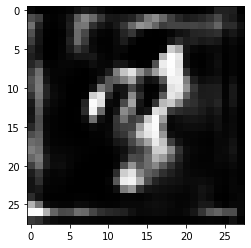

In [16]:
show_new_image(generator)

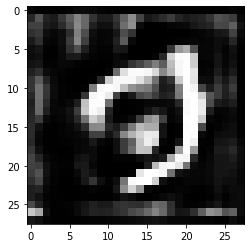

In [17]:
show_new_image(generator)

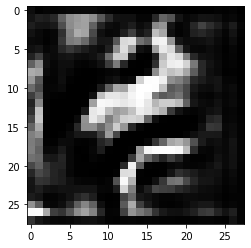

In [18]:
show_new_image(generator)

# Exercise Option #1 - Standard Difficulty
Change the model so that it learns to produce 9x9 images of some simple pattern, for instance horizontal lines.

# Exercise Option #2 - Advanced Difficulty
Change the model so that you can select which number you get an image of rather than always getting a random one. I highly recommend that you limit your model to only learning two or three numbers, so that you can get decent results with less training time.

## Changes made
- Change the discriminator output format to three neurons with a softmax layer.
    - **Justification**: In order to have control over which digit is generated, we need to have the discriminator classify the incoming images into three classes: `0`, `1`, and `fake`. Simply using a single neuron as a binary output would work only if we were only trying to generate one digit at a time.
- Decrease the complexity of the discriminator, removing two convolutional layers and decreasing the number of filters in the remaining two layers to `8` and `16`.
    - **Justification**: If the discriminator is too complex or is able to determine whether or not the provided image is real or fake with extremely high accuracy (and low loss), then it is difficult for the generator to learn how to update its outputs to better fool the discriminator. Consequently, it is likely that the discriminator fails to produce digit-like outputs.
- Add another `2` neurons as input to the generator (concatenated to the noise).
    - This allows us to specify to the generator which digit we want outputted and provide "target labels" for the discriminator to output when training the generator's weights.
        - Initially, discriminator "target label" specification was set as a uniform distribution among all non-`fake` outputs, but this caused the model to generate "hybrid"-like characters (i.e., a character looking both like a zero and a one). Specifying random non-`fake` labels was also tested, but this prevented the generator's loss from decreasing as it did not know *which* digit to generate an image for.
- Updated the `save_imgs` function to generate both `0`s and `1`s in a specific pattern to demonstrate the ability to select for specific generator outputs.
    

# Exercise Option #3 - Advanced Difficulty
You may notice the current GAN with 2000 iterations only gives so-so output. Unfortunately, if you keep training past this point, the output just gets worse. I haven't yet been able to figure out how to change the model to get better results. Can you?